In [18]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.7M Feb 12 11:01 data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  21M Feb 12 10:59 data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  14M Feb 12 10:59 data/Mir.csv.bz2


In [20]:
name_dataset = 'Mir'

### load data

In [21]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(83321, 4)
CPU times: user 5.34 s, sys: 83.6 ms, total: 5.43 s
Wall time: 5.43 s


In [22]:
df.head()

,date,topic,text,predict
0,2008-02-11 10:51:00,"""В России""","['добиваться', 'выдвижение', 'кандидат', 'сша'...",Мир
1,2008-02-11 12:15:00,"""В России""","['министр', 'оборона', 'сша', 'роберт', 'гейтс...",Мир
2,2008-02-11 12:46:00,"""В России""","['сша', 'продолжаться', 'сезон', 'предваритель...",Мир
3,2008-02-11 13:16:00,"""В России""","['американский', 'военнослужащий', 'задержать'...",Мир
4,2008-02-11 16:14:00,"""В России""","['сербия', 'случай', 'признание', 'некоторый',...",Мир


* parse data

In [23]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head()

,date,topic,text,predict,year,month
0,2008-02-11 10:51:00,"""В России""","['добиваться', 'выдвижение', 'кандидат', 'сша'...",Мир,2008,2
1,2008-02-11 12:15:00,"""В России""","['министр', 'оборона', 'сша', 'роберт', 'гейтс...",Мир,2008,2
2,2008-02-11 12:46:00,"""В России""","['сша', 'продолжаться', 'сезон', 'предваритель...",Мир,2008,2
3,2008-02-11 13:16:00,"""В России""","['американский', 'военнослужащий', 'задержать'...",Мир,2008,2
4,2008-02-11 16:14:00,"""В России""","['сербия', 'случай', 'признание', 'некоторый',...",Мир,2008,2


In [24]:
df.text = df.text.apply(lambda x: literal_eval(x))

In [25]:
df.year.value_counts()

2017    10149
2016    10020
2018     9034
2013     8802
2015     8500
2014     7415
2009     6877
2012     6347
2008     5590
2011     5352
2010     4860
2019      375
Name: year, dtype: int64

In [26]:
df.month.value_counts()

3     7845
10    7476
4     7386
11    7204
7     6907
9     6838
8     6761
12    6698
5     6653
1     6624
6     6532
2     6397
Name: month, dtype: int64

### preprocess if text with lemma

In [27]:
df['text_join'] = df.text.apply(lambda x: ' '.join(x))
df.head()

,date,topic,text,predict,year,month,text_join
0,2008-02-11 10:51:00,"""В России""","[добиваться, выдвижение, кандидат, сша, демокр...",Мир,2008,2,добиваться выдвижение кандидат сша демократиче...
1,2008-02-11 12:15:00,"""В России""","[министр, оборона, сша, роберт, гейтс, моджахе...",Мир,2008,2,министр оборона сша роберт гейтс моджахед афга...
2,2008-02-11 12:46:00,"""В России""","[сша, продолжаться, сезон, предварительный, вы...",Мир,2008,2,сша продолжаться сезон предварительный выбор п...
3,2008-02-11 13:16:00,"""В России""","[американский, военнослужащий, задержать, япон...",Мир,2008,2,американский военнослужащий задержать японский...
4,2008-02-11 16:14:00,"""В России""","[сербия, случай, признание, некоторый, независ...",Мир,2008,2,сербия случай признание некоторый независимост...


* cleanedNames

In [28]:
from cleanedNames import KeyProc
cn = KeyProc()

In [29]:
%%time
df.text_join = df.text_join.apply(cn.replaceKeywords)

CPU times: user 1min 12s, sys: 12.4 ms, total: 1min 12s
Wall time: 1min 12s


In [30]:
df.text = df.text_join.apply(lambda x: x.split(' ')) 
df.head()

,date,topic,text,predict,year,month,text_join
0,2008-02-11 10:51:00,"""В России""","[добиваться, выдвижение, кандидат, сша, демокр...",Мир,2008,2,добиваться выдвижение кандидат сша демократиче...
1,2008-02-11 12:15:00,"""В России""","[министр, оборона, сша, роберт_гейтс, моджахед...",Мир,2008,2,министр оборона сша роберт_гейтс моджахед афга...
2,2008-02-11 12:46:00,"""В России""","[сша, продолжаться, сезон, предварительный, вы...",Мир,2008,2,сша продолжаться сезон предварительный выбор п...
3,2008-02-11 13:16:00,"""В России""","[американский, военнослужащий, задержать, япон...",Мир,2008,2,американский военнослужащий задержать японский...
4,2008-02-11 16:14:00,"""В России""","[сербия, случай, признание, некоторый, независ...",Мир,2008,2,сербия случай признание некоторый независимост...


* add docID

In [31]:
df['docID'] = list(range(df.shape[0]))

In [32]:
df.rename(columns={'text':'lemmatized_text'},inplace=True)

In [33]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[добиваться, выдвижение, кандидат, сша, демокр..."
1,1,2008,2,"[министр, оборона, сша, роберт_гейтс, моджахед..."


In [34]:
print(df.shape)
df.isnull().sum()

(83321, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [35]:
df.year.min(),df.year.max()

(2008, 2019)

### preprocess if text full

* get dates

In [ ]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

* clean text

In [ ]:
import preprocessing_tools as pr

In [ ]:
%%time
df.text = df.text.apply(pr.clean_text)

In [ ]:
df.head(2)

* cleanedNames

In [ ]:
from cleanedNames import KeyProc
cn = KeyProc()

In [ ]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

* lemmatization

In [ ]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

* add docID

In [ ]:
df['docID'] = list(range(df.shape[0]))

In [ ]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

In [ ]:
print(df.shape)
df.isnull().sum()

In [ ]:
df.year.min()

## model

* prepare

In [36]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 584 ms, sys: 113 ms, total: 696 ms
Wall time: 695 ms


In [37]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [38]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/Mir", num_batches=84)
CPU times: user 23.8 s, sys: 497 ms, total: 24.3 s
Wall time: 5.15 s


In [39]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [40]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=4fbddefa-0864-4901-b1d3-846238f5bfb3, num_entries=23074)

In [41]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 6
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

In [ ]:
#model_list

In [ ]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [ ]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

In [ ]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

In [ ]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [ ]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

In [ ]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

In [ ]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [ ]:
perplexity

### select the best model

In [ ]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

In [ ]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

---

In [42]:
select_topics = 17

In [43]:
num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')


	SparsityThetaScore: 0.6766297817230225
	SparsityPhiScore: 0.855095386505127
	PerplexityScore: 2171.374267578125


In [44]:
best_model = model.clone()
best_model.num_topics

17

---

### print top words for each topics

In [45]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['землетрясение' 'остров' 'япония' 'судно' 'японский' 'китайский' 'судный'
 'километр' 'китай' 'экипаж']
topic_1: ['партия' 'трамп' 'выбор' 'пост' 'дональд_трамп' 'кандидат'
 'президентский' 'парламент' 'голос' 'выборы']
topic_2: ['ес' 'украина' 'европейский' 'германия' 'европа' 'совет' 'евросоюз'
 'великобритания' 'брюссель' 'соглашение']
topic_3: ['самолёт' 'корабль' 'полёт' 'нато' 'ввс' 'воздушный' 'оборона' 'база'
 'вмс' 'граница']
topic_4: ['миллион' 'санкция' 'случай' 'миллиард' 'список' 'ввести' 'финансовый'
 'запрет' 'новый' 'помощь']
topic_5: ['корея' 'кндр' 'южный' 'ракета' 'северный' 'ядерный' 'китай' 'пхеньян'
 'северокорейский' 'южнокорейский']
topic_6: ['подчеркнуть' 'проблема' 'иф' 'хотеть' 'добавить' 'ситуация' 'встреча'
 'очень' 'москва' 'важный']
topic_7: ['расследование' 'великобритания' 'сотрудник' 'бывший' 'издание'
 'обвинение' 'спецслужба' 'саудовский' 'документ' 'разведка']
topic_8: ['оон' 'мид' 'посольство' 'резолюция' 'оружие' 'дипломат' 'совет' 'посо

### get topics-docs matrix

shape theta: (17, 83321)


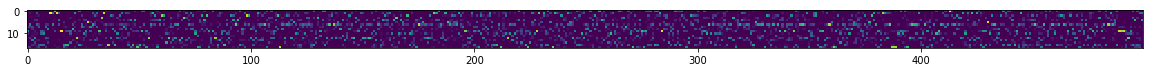

In [46]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [47]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
1000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.061938,0.000000,0.000000,0.000000,0.0,0.0,0.748309,0.000000,0.189754,0.000000,0.00000
1001,0.00000,0.000000,0.0,0.0,0.000000,0.794924,0.000000,0.099766,0.105309,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
1002,0.04213,0.000000,0.0,0.0,0.040718,0.000000,0.103612,0.015686,0.000000,0.050252,0.0,0.0,0.050809,0.000000,0.000000,0.376552,0.32024
1003,0.00000,0.778902,0.0,0.0,0.000000,0.000000,0.068119,0.000000,0.000000,0.000000,0.0,0.0,0.125237,0.000000,0.027742,0.000000,0.00000
1004,0.00000,0.381670,0.0,0.0,0.097835,0.000000,0.198867,0.159424,0.038356,0.000000,0.0,0.0,0.000000,0.123848,0.000000,0.000000,0.00000


## DataViz

In [48]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
0,0,2008,2,0.000000,0.896131,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020551,0.0,0.000000,0.0,0.000000,0.083318
1,1,2008,2,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.437453,0.000000,0.000000,0.000000,0.385207,0.103588,0.0,0.000000,0.0,0.047002,0.026750
2,2,2008,2,0.000000,0.730216,0.0,0.0000,0.084504,0.000000,0.148614,0.001143,0.000000,0.000000,0.003306,0.018500,0.0,0.000000,0.0,0.000000,0.013718
3,3,2008,2,0.072363,0.027139,0.0,0.0176,0.000000,0.084604,0.141986,0.064175,0.016575,0.042111,0.108072,0.038602,0.0,0.194688,0.0,0.192084,0.000000
4,4,2008,2,0.000000,0.087549,0.0,0.0000,0.000000,0.000000,0.276949,0.000000,0.114875,0.000000,0.000000,0.000000,0.0,0.473218,0.0,0.000000,0.047409


In [49]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (132, 17)


topic_0    topic_1    topic_2    topic_3    topic_4    topic_5  \
year month                                                                     
2008 2       8.179199  16.516285  13.092167   4.357880   3.893012   4.856283   
     3      16.274590  39.991135  33.744358  11.809440  23.156374  15.451864   
     4      22.307673  30.961851  37.921185  10.627771  26.490026  19.853451   
     5      56.661697  32.488544  24.227848  13.323477  31.041460  15.437386   
     6      36.224133  27.064926  21.726618   8.193975  25.176136   7.978942   

              topic_6    topic_7    topic_8    topic_9   topic_10   topic_11  \
year month                                                                     
2008 2      20.093887   8.312083  19.245304  18.904638  10.635338  10.580479   
     3      50.420071  17.316294  26.878107  36.908100  27.859682  19.416115   
     4      47.734909  17.248766  23.308163  37.319473  26.312138   9.283325   
     5      34.586071  15.041763  26.062679  71.032143  13.671349  20.884666   
     6      31.983164  11.507882  15.921509  51.177929  17.875755   9.600220   

             topic_12   topic_13   topic_14   topic_15   topic_16  
year month                                                         
2008 2       7.026897  22.809958   3.910734  17.466988  11.118870  
     3      25.610094  31.561165  11.049801  29.673306  19.879511  
     4      20.704447  32.268055  11.111181  36.253178  27.294407  
     5      21.029957  15.964109  17.513908  21.322330  31.710615  
     6      19.476995  18.535898   9.032600  21.002302  20.521015

### straightforward matrix heatmap

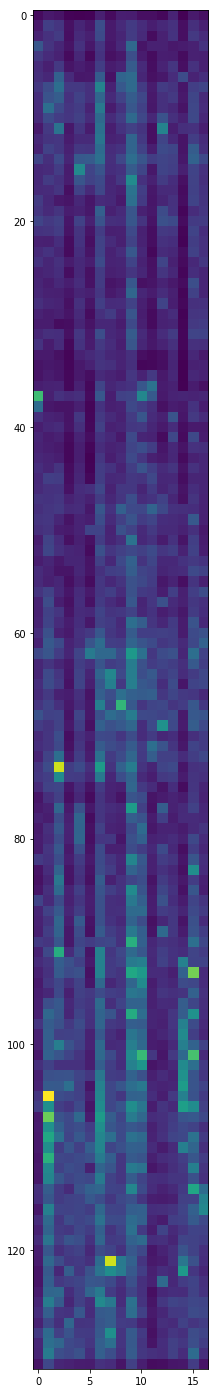

In [51]:
plt.figure(figsize=(5, 25))
plt.imshow(gb[topics])

## pygal

In [52]:
import pygal
from IPython.display import SVG, HTML

In [53]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [54]:
max(gb['topic_1'].values)

204.15836

In [55]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [56]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [57]:
import joypy # !pip install joypy

In [58]:
print(joined.shape)
joined.head()

(83321, 20)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
0,0,2008,2,0.000000,0.896131,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020551,0.0,0.000000,0.0,0.000000,0.083318
1,1,2008,2,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.437453,0.000000,0.000000,0.000000,0.385207,0.103588,0.0,0.000000,0.0,0.047002,0.026750
2,2,2008,2,0.000000,0.730216,0.0,0.0000,0.084504,0.000000,0.148614,0.001143,0.000000,0.000000,0.003306,0.018500,0.0,0.000000,0.0,0.000000,0.013718
3,3,2008,2,0.072363,0.027139,0.0,0.0176,0.000000,0.084604,0.141986,0.064175,0.016575,0.042111,0.108072,0.038602,0.0,0.194688,0.0,0.192084,0.000000
4,4,2008,2,0.000000,0.087549,0.0,0.0000,0.000000,0.000000,0.276949,0.000000,0.114875,0.000000,0.000000,0.000000,0.0,0.473218,0.0,0.000000,0.047409


In [59]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,date
0,0,2008,2,0.000000,0.896131,0.0,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.020551,0.0,0.000000,0.0,0.000000,0.083318,2008-02-01
1,1,2008,2,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.437453,...,0.000000,0.000000,0.385207,0.103588,0.0,0.000000,0.0,0.047002,0.026750,2008-02-01
2,2,2008,2,0.000000,0.730216,0.0,0.0000,0.084504,0.000000,0.148614,...,0.000000,0.000000,0.003306,0.018500,0.0,0.000000,0.0,0.000000,0.013718,2008-02-01
3,3,2008,2,0.072363,0.027139,0.0,0.0176,0.000000,0.084604,0.141986,...,0.016575,0.042111,0.108072,0.038602,0.0,0.194688,0.0,0.192084,0.000000,2008-02-01
4,4,2008,2,0.000000,0.087549,0.0,0.0000,0.000000,0.000000,0.276949,...,0.114875,0.000000,0.000000,0.000000,0.0,0.473218,0.0,0.000000,0.047409,2008-02-01


In [60]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd.head()

,date,topic,mentions
3,2008-02-01,topic_0,0.072363
5,2008-02-01,topic_0,0.048021
6,2008-02-01,topic_0,0.014452
7,2008-02-01,topic_0,0.176665
17,2008-02-01,topic_0,0.003293


In [61]:
dd2 = dd.groupby(['date','topic']).sum()
dd2.head()

mentions
date       topic              
2008-02-01 topic_0    8.179199
           topic_1   16.516285
           topic_10  10.635338
           topic_11  10.580479
           topic_12   7.026897

In [62]:
dd2=dd2.reset_index()
dd2.head()

,date,topic,mentions
0,2008-02-01,topic_0,8.179199
1,2008-02-01,topic_1,16.516285
2,2008-02-01,topic_10,10.635338
3,2008-02-01,topic_11,10.580479
4,2008-02-01,topic_12,7.026897


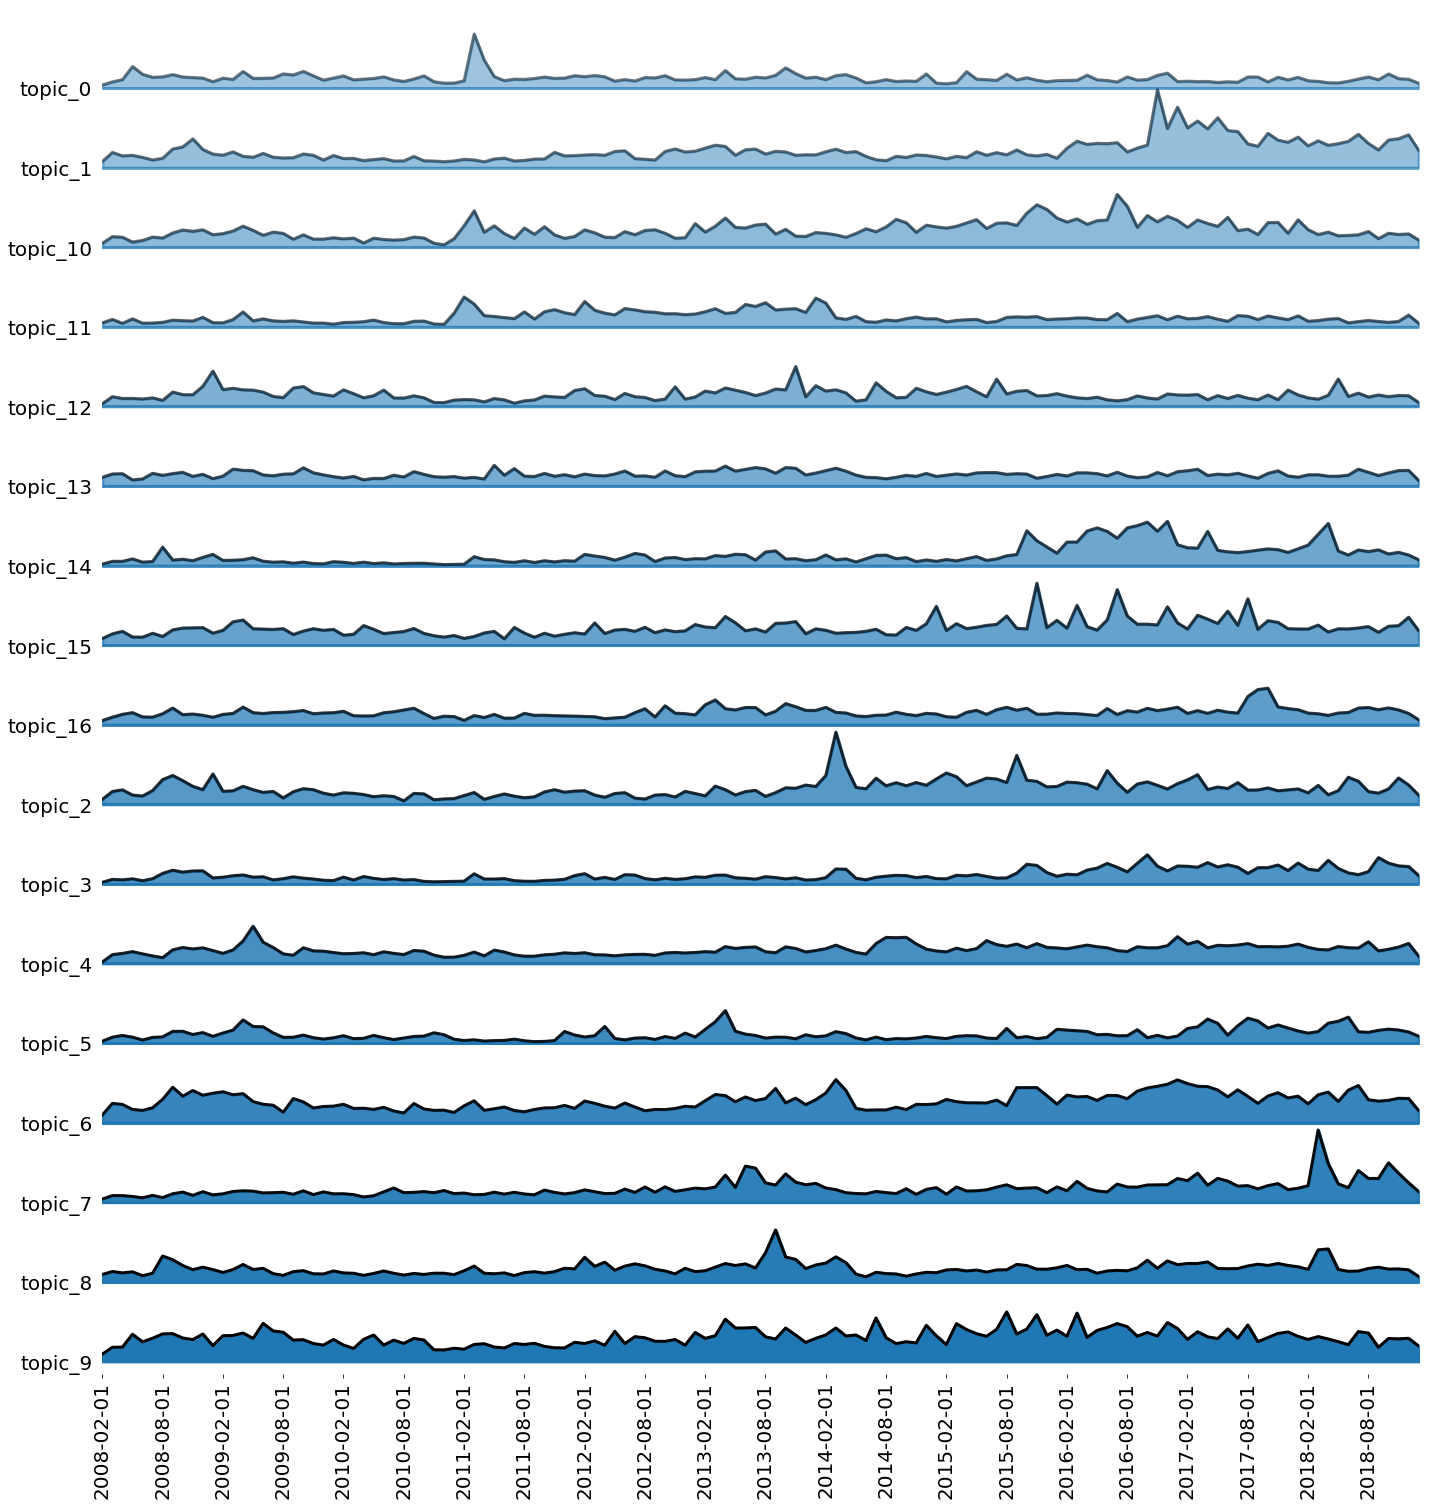

In [63]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [64]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")